In [1]:
import os
import tensorflow.keras as keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

Using TensorFlow backend.


In [0]:
# 此函數會幫我們把多張影像畫成一張多宮格圖
def img_combine(img, ncols=8, size=1, path=False):
    from math import ceil
    import matplotlib.pyplot as plt
    import numpy as np
    nimg = len(img)
    nrows = int(ceil(nimg/ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(ncols*size,nrows*size))
    if nrows == 0:
        return
    elif ncols == 1:
        for r, ax in zip(np.arange(nrows), axes):
            nth=r
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                
            ax.set_axis_off()
    elif nrows == 1:
        for c, ax in zip(np.arange(ncols), axes):
            nth=c
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
            ax.set_axis_off()
    else:
        for r, row in zip(np.arange(nrows), axes):
            for c, ax in zip(np.arange(ncols), row):
                nth=r*ncols+c
                if nth < nimg:
                    ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                ax.set_axis_off()
    plt.show()

In [0]:
# 讀取 Cifar-10 資料集
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

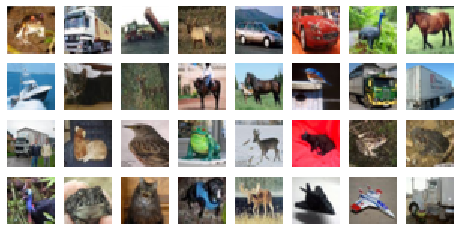

In [49]:
# 取前 32 張圖片做視覺化
images = x_train[:32]
img_combine(images)

In [0]:
# 建立 ImageDataGenerator，並指定我們要做資料增強的數值範圍
data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

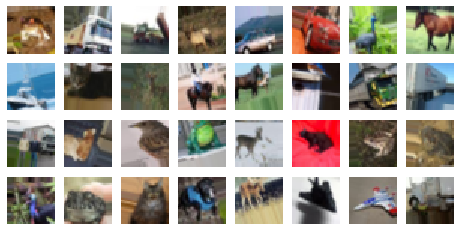

In [51]:
# 注意！！ ImageDataGenerator 是一個 Generator (生成器)! 對 Generator 不熟悉的同學請回到 Day098 做複習。
# 使用 .flow 後，就會對我們的影像進行增強，再 call next 取出 generator 的圖像。(shuffle=False 因為我們希望圖像的順序不要改變，方便觀察。實際訓練時預設是 shuffle=True) 
augmented_iamges = next(data_generator.flow(images, shuffle=False))
img_combine(augmented_iamges.astype("int")) # 注意在訓練時神經網路時，圖像資料必須要是 float32，但在做視覺化時要轉為 int 才能順利畫圖。所以為了畫圖才把資料轉為 int

(32, 32, 32, 3)


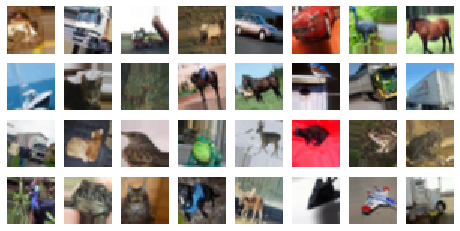

In [52]:
# 因為隨機性的關係，所以一樣的圖像再經過一次 generator 後的結果不一定相同
augmented_iamges = next(data_generator.flow(images, shuffle=False))
print(augmented_iamges.shape)
img_combine(augmented_iamges.astype("int"))

## 作業

請使用 ImageDataGenerator 來進行 Cifar-10 資料集的訓練，並觀察不同的圖像增強方法是否會顯著影響訓練結果

In [0]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop, Adam
import os

In [0]:
batch_size = 128 # batch 的大小，如果出現 OOM error，請降低這個值
num_classes = 10 # 類別的數量，Cifar 10 共有 10 個類別
epochs = 50 # 訓練的 epochs 數量

## 使用前

In [6]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [0]:
# 影像 generator
def cifar_generator(image_array, batch_size=32):
    while True:
        for indexs in range(0, len(image_array), batch_size):
            images = x_train[indexs: indexs+batch_size]
            labels = y_train[indexs: indexs+batch_size]
            yield images, labels
            
cifar_gen = cifar_generator(x_train, batch_size)

In [0]:
# create cifar10 generator
generator_batch_size = 32
cifar_gen = cifar_generator(x_train, batch_size=generator_batch_size)

In [58]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_25 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_26 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 15, 15, 64)       

In [59]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

# history = model.fit(x_train, y_train,
#                     batch_size=batch_size,
#                     epochs=epochs,
#                     verbose=1,
#                     validation_data=(x_test, y_test))

# 改成採用 generator 產生處理的資料
history = model.fit_generator(cifar_gen,
                              steps_per_epoch=(len(x_train) / generator_batch_size),
                              epochs=epochs,
                              verbose=1,
                              validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/50
1563/1562 [==============================] - 23s 15ms/step - loss: 1.5250 - acc: 0.4549 - val_loss: 1.1923 - val_acc: 0.5758
Epoch 2/50
1563/1562 [==============================] - 22s 14ms/step - loss: 1.1117 - acc: 0.6110 - val_loss: 0.8955 - val_acc: 0.6915
Epoch 3/50
1563/1562 [==============================] - 22s 14ms/step - loss: 1.0055 - acc: 0.6572 - val_loss: 0.9529 - val_acc: 0.6736
Epoch 4/50
1563/1562 [==============================] - 22s 14ms/step - loss: 0.9724 - acc: 0.6725 - val_loss: 1.0996 - val_acc: 0.6524
Epoch 5/50
1563/1562 [==============================] - 22s 14ms/step - loss: 0.9854 - acc: 0.6720 - val_loss: 1.0007 - val_acc: 0.6763
Epoch 6/50
1563/1562 [==============================] - 22s 14ms/step - loss: 1.0098 - acc: 0.6688 - val_loss: 1.0129 - val_acc: 0.6625
Epoch 7/50
1563/1562 [==============================] - 22s 14ms/step - loss: 1.0589 - acc: 0.6564 - val_loss: 1.0279 - val_acc: 0.6821
Epoch 8/50
1563/1562 [==========================

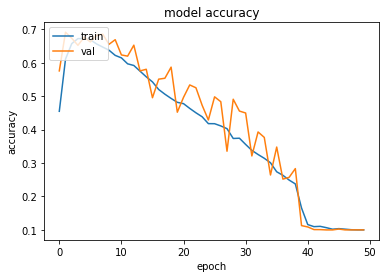

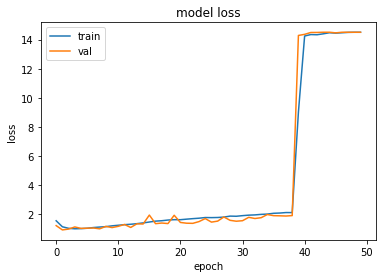

In [60]:
from matplotlib import pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## 使用 augmentation

In [8]:
# 讀取 Cifar-10 資料集
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# 做 augmentation 前，不能做 normalization
# x_train /= 255
x_test /= 255

# Convert class vectors to binary class matrices.
# 對 label 進行 one-hot encoding (y_trian 原本是純數字)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [0]:
# 影像 generator + ImageDataGenerator
def cifar_generator(image_array, batch_size=32):
    while True:
        for indexs in range(0, len(image_array), batch_size):
            images = x_train[indexs: indexs+batch_size]
            labels = y_train[indexs: indexs+batch_size]
            images = next(data_generator.flow(images, shuffle=False))
            images = images.astype('float32')
            images /= 255
            yield images, labels

In [0]:
# create cifar10 generator
generator_batch_size = 32
cifar_gen = cifar_generator(x_train, batch_size=generator_batch_size)

# images, labels = next(cifar_gen)
# images.shape
## (32, 32, 32, 3)

In [12]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         


In [13]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

# history = model.fit(x_train, y_train,
#                     batch_size=batch_size,
#                     epochs=epochs,
#                     verbose=1,
#                     validation_data=(x_test, y_test))

# 改成採用 generator 產生處理的資料
history = model.fit_generator(cifar_gen,
                              steps_per_epoch=(len(x_train) / generator_batch_size),
                              epochs=epochs,
                              verbose=1,
                              validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/50





1563/1562 [==============================] - 37s 24ms/step - loss: 1.7597 - acc: 0.3486 - val_loss: 1.4955 - val_acc: 0.4657
Epoch 2/50
1563/1562 [==============================] - 30s 20ms/step - loss: 1.4728 - acc: 0.4698 - val_loss: 1.4162 - val_acc: 0.5064
Epoch 3/50
1563/1562 [==============================] - 31s 20ms/step - loss: 1.4012 - acc: 0.5045 - val_loss: 1.4073 - val_acc: 0.5502
Epoch 4/50
1563/1562 [==============================] - 30s 19ms/step - loss: 1.3679 - acc: 0.5211 - val_loss: 1.3586 - val_acc: 0.5420
Epoch 5/50
1563/1562 [==============================] - 31s 20ms/step - loss: 1.3756 - acc: 0.5232 - val_loss: 1.3041 - val_acc: 0.5492
Epoch 6/50
1563/1562 [==============================] - 31s 20ms/step - loss: 1.3845 - acc: 0.5245 - val_loss: 1.4245 - val_acc: 0.5344
Epoch 7/50
1563/1562 [==============================] - 31s 20ms/step - loss: 1.

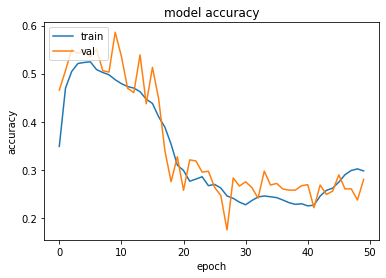

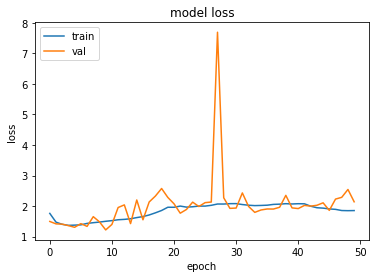

In [14]:
from matplotlib import pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()